# Ovary Pilot scRNA-Seq

In [1]:
import os
import sys
from pathlib import Path
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from IPython.display import HTML

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import gffutils

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot

# Setup notebook
nbconfig = Nb.setup_notebook('ovary_pilot_scRNAseq_analysis')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

%reload_ext rpy2.ipython

last updated: 2018-01-29 
Git hash: 36227490cf459648a0404719b23b7927435f5bc0


Cell ranger from 10x genomics was used to do alignments and UMI demultiplexing. The web report can be found [here](http://geneticsunderground.com/larval_gonad/reports/ovary_web_summary.html).

In [2]:
REF = os.environ['REFERENCES_DIR']
OUTPUT = '../output/ovary_scRNAseq_pilot'
Path(OUTPUT).mkdir(exist_ok=True)

# Import gene annotations
fbgn2symbol = pd.read_csv(str(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation')), sep='\t', 
                          usecols=['gene_symbol', 'primary_FBgn'], index_col='primary_FBgn').to_dict()['gene_symbol']

symbol2fbgn = pd.read_csv(str(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation')), sep='\t', 
                          usecols=['gene_symbol', 'primary_FBgn'], index_col='gene_symbol').to_dict()['primary_FBgn']

In [3]:
# Get genes on mitochondria DNA
db = gffutils.FeatureDB(os.path.join(REF, 'dmel/r6-16/gtf/dmel_r6-16.gtf.db'))

onM = []
for gene in db.features_of_type('gene'):
    if gene.chrom == 'chrM':
        onM.append(gene.id)

onM = sorted(onM)

In [4]:
conda_info = !conda info
for x in conda_info:
    if 'envs directories' in x:
        CONDA_ENV = x.split(':')[1].strip()

In [5]:
%%R -i REF -i OUTPUT -i CONDA_ENV
# Import R libraries
.libPaths(paste0(CONDA_ENV, "/larval_gonad/lib/R/library"))
library(Seurat)
library(dplyr)
library(Matrix)

Here we use [Seurat](http://satijalab.org/seurat/) for the initial analysis. From their website:

>Seurat is an R package designed for QC, analysis, and exploration of single cell RNA-seq data. Seurat aims to enable users to identify and interpret sources of heterogeneity from single cell transcriptomic measurements, and to integrate diverse types of single cell data.

## Data Download
* Data generated by Seurat and this analysis can be downloaded
[here](https://helix.nih.gov/~fearjm/larval_gonad/ovary_scRNAseq_pilot.tgz).

* tSNE for all genes can be downloaded [here](https://helix.nih.gov/~fearjm/larval_gonad/ovary_tsne.tgz)

## Quality Control

We keep all genes that are expressed in **≥3 cells**, and we kept all cells that capture **≥200 detected genes**. The vast majority of cells have around 2,000 touched genes, with some cells having more than 6,000 detected genes. The distribution of number of unique molecular indices (nUMI) is much tighter with the majority of cells having around 10,000 UMI. The number of detected genes is moderately correlated with the UMI count. We expect nGenes and UMI to be highly correlated because as we capture more genes we should capture more unique molecules.

In [6]:
%%R -o meta_data -o raw_data -i onM
# Load the ovary dataset
ovary.data = Read10X(data.dir="../output/ovary1/outs/filtered_gene_bc_matrices/dm6.16")

# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes
ovary = CreateSeuratObject(raw.data = ovary.data, min.cells = 3, min.genes = 200, project = "10X_ovary")

# calculate the percent genes on chrom M
mask = row.names(ovary@raw.data) %in% onM
percent.mito <- Matrix::colSums(ovary@raw.data[mask, ]/Matrix::colSums(ovary@raw.data)) * 100
ovary <- AddMetaData(object = ovary, metadata = percent.mito, col.name = "percent_mito")

nCells = dim(ovary@meta.data)[1]
meta_data = as.data.frame(ovary@meta.data)
raw_data = as.data.frame(as.matrix(ovary@raw.data))

write.table(meta_data,
            file=file.path(OUTPUT, 'metadata.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(raw_data,
            file=file.path(OUTPUT, 'raw.tsv'),
            quote=FALSE, sep='\t', row.names=TRUE, col.names=TRUE)

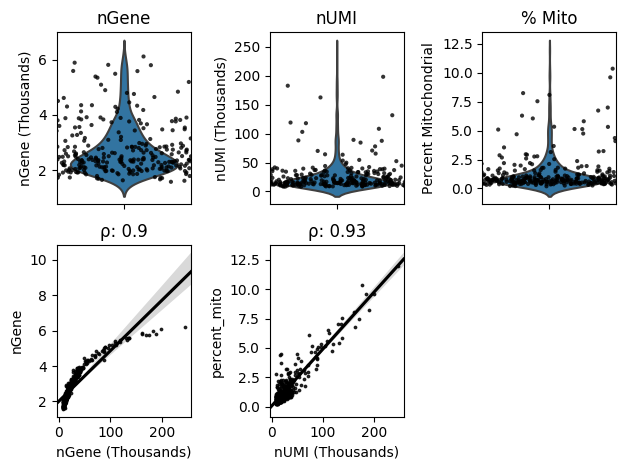

In [7]:
# Plot distribution of gene counts and UMI counts
@make_figs(nbconfig.fig_name('nGene_nUMI_panel'),
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot_nGene_nUMI_panel():
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
    
    sns.violinplot(y=meta_data.nGene / 1000, ax=ax1, inner=None)
    sns.stripplot(y=meta_data.nGene / 1000, color='k', ax=ax1, jitter=1.02, size=3, alpha=.8)

    ax1.set_title('nGene')
    ax1.set_ylabel('nGene (Thousands)')

    sns.violinplot(y=meta_data.nUMI / 1000, ax=ax2, inner=None)
    sns.stripplot(y=meta_data.nUMI / 1000, ax=ax2, color='k', jitter=1.02, size=3, alpha=.8)

    ax2.set_title('nUMI')
    ax2.set_ylabel('nUMI (Thousands)')

    sns.violinplot(y=meta_data.percent_mito, ax=ax3, inner=None)
    sns.stripplot(y=meta_data.percent_mito, ax=ax3, color='k', jitter=1.02, size=3, alpha=.8)

    ax3.set_title('% Mito')
    ax3.set_ylabel('Percent Mitochondrial')
    
    sns.regplot('nUMI', 'nGene', meta_data[['nUMI', 'nGene']] / 1000, color='k', ax=ax4, scatter_kws={'s': 3})
    rho = np.round(stats.pearsonr(meta_data.nGene, meta_data.nUMI)[0], 2)
    ax4.set_title(f'ρ: {rho}')
    ax4.set_xlabel('nUMI (Thousands)')
    ax4.set_xlabel('nGene (Thousands)')

    sns.regplot('nUMI', 'percent_mito', pd.concat([meta_data.nUMI / 1000, meta_data.percent_mito], axis=1), color='k', ax=ax5, scatter_kws={'s': 3})
    rho = np.round(stats.pearsonr(meta_data.percent_mito, meta_data.nUMI)[0], 2)
    ax5.set_title(f'ρ: {rho}')
    ax5.set_xlabel('nUMI (Thousands)')    
    ax6.set_visible(False)

    plt.tight_layout()
    
plot_nGene_nUMI_panel()

To try to avoid cells that behave like outliers, we filtered cells that had a gene count ≤200 or ≥6,000. 

**Note: I would also like to remove cells that have a ≥5% mitochondrial expression only (~136 cells), but this causes 1 of the clusters to drop out. Need to explore more.**

In [8]:
%%R
#ovary = FilterCells(object=ovary, subset.names=c("nGene", "percent_mito"), low.thresholds=c(200, -Inf), high.thresholds=c(6000, 5))

ovary = FilterCells(object=ovary, subset.names=c("nGene"), low.thresholds=c(200), high.thresholds=c(6000))

There is good correlation between nGene and nUMI suggests that the majority of genes will have an overall low number of reads / gene. Looking at the distribution of cells with ≤1 read per gene or ≤5 reads per gene shows that the majority of cells have around 83 percent of genes with 1 or fewer reads.

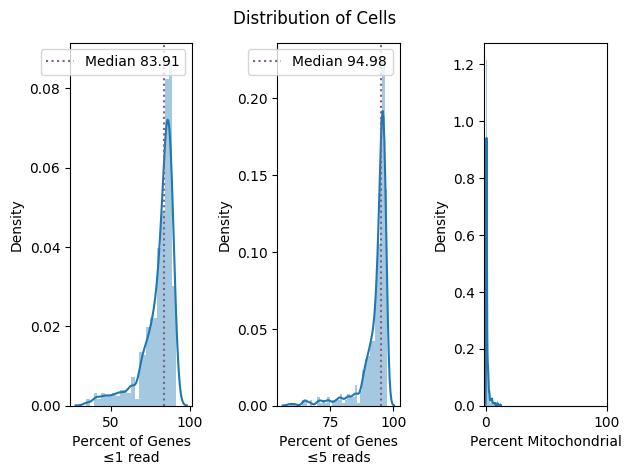

In [9]:
@make_figs(nbconfig.fig_name('distribution_percent_low_count_genes'), styles=nbconfig.styles_wide, 
          kws_layout={'rect': [0, 0, 1, .95]})
def _plot():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    low1 = (raw_data <= 1).sum() / raw_data.shape[0] * 100
    low1med = low1.median()
    low2 = (raw_data <= 5).sum() / raw_data.shape[0] * 100
    low2med = low2.median()

    sns.distplot(low1, ax=ax1)
    ax1.axvline(low1med, ls=':', color=nbconfig.color_c1, label=f'Median {low1med:0.2f}')
    ax1.set_xlabel("Percent of Genes\n≤1 read")
    ax1.set_ylabel('Density')
    ax1.legend()

    sns.distplot(low2, ax=ax2)
    ax2.axvline(low2med, ls=':', color=nbconfig.color_c1, label=f'Median {low2med:0.2f}')    
    ax2.set_xlabel("Percent of Genes\n≤5 reads")
    ax2.set_ylabel('Density')
    ax2.legend()

    sns.distplot(meta_data.percent_mito, ax=ax3)
    ax3.set_xlim(None, 100)
    ax3.set_xlabel('Percent Mitochondrial')
    ax3.set_ylabel('Density')
    
    plt.suptitle('Distribution of Cells')
    
_plot()

## Normalization

Next we normalized the data. Seurat's normalizes gene expression by the total expression for each cell, multiplies by a scaling factors (10,000), and takes the natural log.

In [10]:
%%R -o norm
ovary = NormalizeData(object=ovary, normalization.method="LogNormalize", scale.factor=1e4)
norm = as.data.frame(as.matrix(ovary@data))

write.table(norm, file=file.path(OUTPUT, 'normalized_read_counts.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

## Variable Genes

Next Seurat identifies variable genes for use in downstream analysis. For doing differential expression and clustering focusing on the variable genes speeds up analysis.  First, average expression and dispersion (variation) are calculated for each gene. Then genes are binned controlling for the relationship between variability and average expression. Here we select genes (n=875) in the white area to carry through to the analysis.

In [11]:
%%R -o dispersion 
### Detection of variable genes across the single cells
ovary = FindVariableGenes(object=ovary, mean.function=ExpMean, dispersion.function=LogVMR, do.plot=FALSE,
                           x.low.cutoff=0.01, 
                           x.high.cutoff=3, 
                           y.cutoff=0.5,
                           y.high.cutoff=Inf
                          )

dispersion = as.data.frame(as.matrix(ovary@hvg.info))

write.table(dispersion,
            file=file.path(OUTPUT, 'dispersion.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

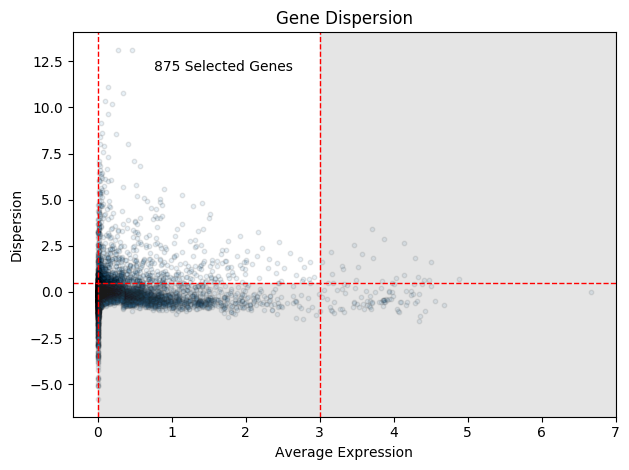

In [12]:
@make_figs(nbconfig.fig_name('gene_dispersion'))
def plot_dispersion():
    _x_low = 0.01
    _x_high = 3
    _y_low = 0.5

    fig, ax = plt.subplots(1, 1)
    ax.scatter(dispersion['gene.mean'], dispersion['gene.dispersion.scaled'], 
                s=10, alpha=.1, edgecolor='k')
    ax.axvline(_x_low, ls='--', lw=1, color='r')
    ax.axvline(_x_high, ls='--', lw=1, color='r')
    ax.axhline(_y_low, ls='--', lw=1, color='r')

    _x_min, _x_max = ax.get_xlim()
    _y_min, _y_max = ax.get_ylim()

    verts = [
        [_x_low, _y_min], 
        [_x_low, _y_low], 
        [_x_high, _y_low], 
        [_x_high, _y_max],
        [_x_max, _y_max],
        [_x_max, _y_min],
    ]
    p1 = mpl.patches.Polygon(verts, color='grey', alpha=.2)
    ax.add_patch(p1)
    ax.set_title('Gene Dispersion')
    ax.set_xlabel('Average Expression')
    ax.set_ylabel('Dispersion')
    
    _num = sum((_x_low < dispersion['gene.mean']) & (_x_high > dispersion['gene.mean']) & (_y_low < dispersion['gene.dispersion.scaled']))
    ax.text(.15, .9, f'{_num:,} Selected Genes', transform=ax.transAxes)
    
plot_dispersion()

## Scaling and regressing out unwanted sources of variation

Next we regress out variability due to the number of UMI. To remove these 'unwanted' sources of variability, Seurat constructs a linear model and predicts gene expression based on the selected variables (i.e., nUMI). The scaled z-scores of the residuals are then used for dimensionality reduction and clustering.

**Note: I would like to regress out the cell to cell variation picked up by mitochondrial expression. However, this caused one of the clusters to be removed so I need to think and discuss this further.**

In [13]:
%%R
ovary = ScaleData(object=ovary, vars.to.regress=c("nUMI"), display.progress=FALSE)

write.table(as.data.frame(ovary@scale.data),
            file=file.path(OUTPUT, 'scaled.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

## Dimensionality Reduction

Next we use PCA to reduce the dimensionality of the dataset. Selection of the number of principal components can be tricky. Here I looked at a variety of metrics and selected 21 PC's for use in remaining analysis.

First I show the typical PCA plot with PC1 vs PC2. As previously discussed, most genes have very low expression/variability and end up clustered near 0. There is a set of a few genes that show a lot of spread on PC1 and a different set that show spread on PC2. Next, I show the top 30 genes with the largest loadings for PC1 and PC2. These genes should be the most variable genes in the data set. Most of them are CGS, but *vas* stands out. Looking at the Elbow plot and Jackstraw plots, using 21 PCs seems reasonable.

In [14]:
%%R -o pca_res -o gene_loadings -o pca_stdev
### Perform linear dimensional reduction
ovary = RunPCA(object=ovary, pc.genes=ovary@var.genes, do.print=FALSE, 
                pcs.print=1:5, genes.print=5, pcs.compute=100)

# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
ovary = ProjectPCA(object=ovary, do.print=FALSE)

pca_res = as.data.frame(ovary@dr$pca@cell.embeddings)
gene_loadings = as.data.frame(ovary@dr$pca@gene.loadings)
pca_stdev = ovary@dr$pca@sdev

write.table(pca_res,
            file=file.path(OUTPUT, 'principal_components_cell.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(gene_loadings,
            file=file.path(OUTPUT, 'principal_components_gene.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

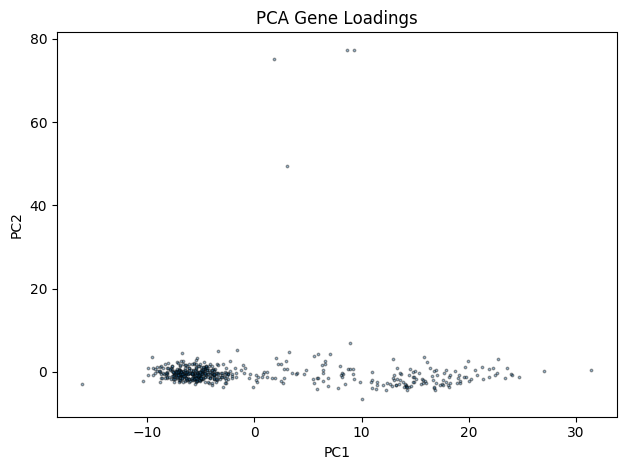

In [15]:
@make_figs(nbconfig.fig_name('pca_plot'), styles=nbconfig.styles)
def plot_pca2():
    # Adjust sign for PCs

    fig, ax = plt.subplots(1, 1)
    ax.scatter(pca_res.PC1, pca_res.PC2, alpha=.4, s=3, edgecolor='k')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA Gene Loadings')
    
plot_pca2()

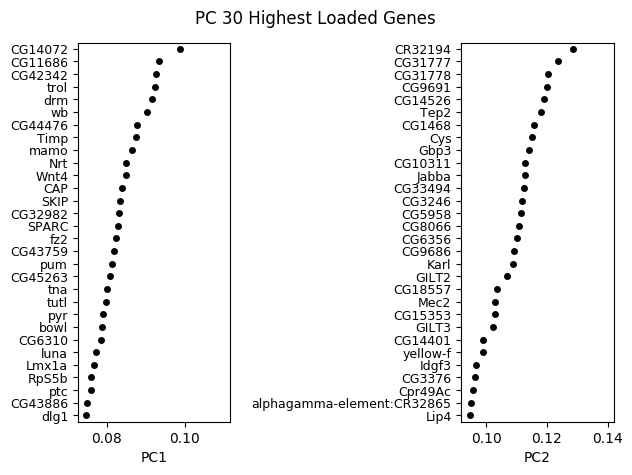

In [21]:
@make_figs(nbconfig.fig_name('pca_highest'), styles=nbconfig.styles_wide, kws_layout={"rect": [0, 0, 1, .95]})
def plot_pca1():
    # Adjust sign for PCs
    ## Sign is irrelavant with PCs, I am curious at looking at most variable
    pc1 = abs(gene_loadings.PC1).sort_values(ascending=False).head(30).reset_index()
    pc2 = abs(gene_loadings.PC2).sort_values(ascending=False).head(30).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2)

    def adjust_font(ax):
        labels = []
        for l in ax.get_yticklabels():
            labels.append(fbgn2symbol[l.get_text()])
        ax.set_yticklabels(labels, fontsize=9)
        
    sns.stripplot(x="PC1", y="index", data=pc1, ax=ax1, color='k')
    #ax1.set_xlim(0.03, 0.033)
    ax1.set_ylabel('')
    adjust_font(ax1)

    sns.stripplot(x="PC2", y="index", data=pc2, ax=ax2, color='k')
    ax2.set_ylabel('')
    adjust_font(ax2)
    
    plt.suptitle('PC 30 Highest Loaded Genes')
    
plot_pca1()

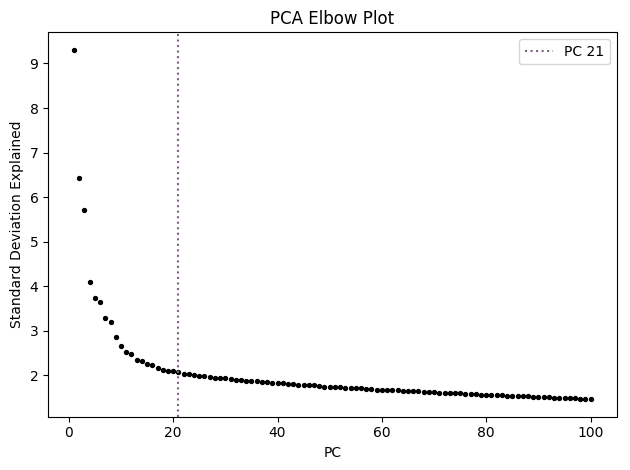

In [51]:
@make_figs(nbconfig.fig_name('pca_elbow'))
def plot_elbow():
    fig, ax = plt.subplots(1, 1)
    ax.scatter(range(1, 101), pca_stdev, color='k', s=8)
    ax.set_xlabel('PC')
    ax.set_ylabel('Standard Deviation Explained')
    ax.set_title('PCA Elbow Plot')
    ax.axvline(21, ls=':', color=nbconfig.color_c1, label='PC 21')
    ax.legend()

plot_elbow()

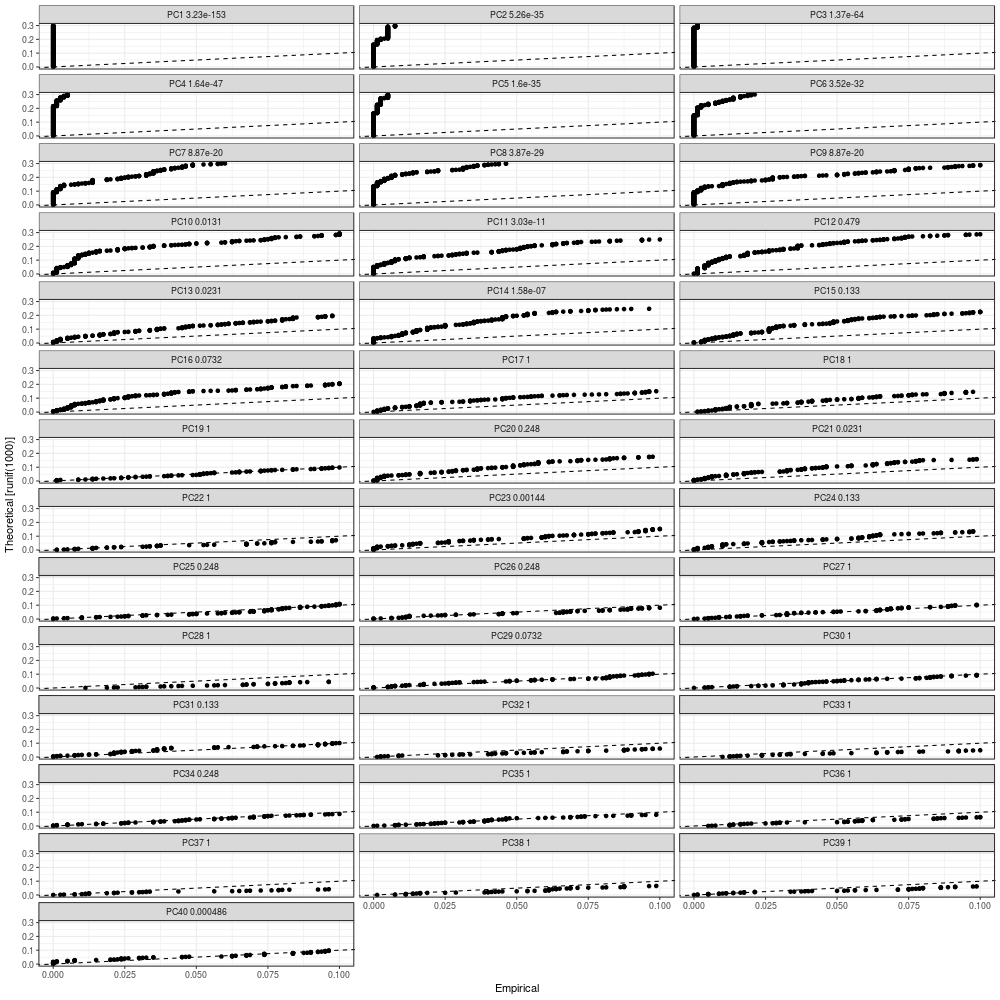

In [19]:
%%R -w 1000 -h 1000
ovary = JackStraw(object=ovary, num.replicate=100, do.print=FALSE, num.pc=40)

JackStrawPlot(object=ovary, PCs=1:40)

## Cluster Cells

Clusters are generated using a graphical K-nearest neighbors approach. This approach draws edges between cells with a similar expression pattern. It then tries to partition connected cells based on their local neighborhoods. For clustering I use the 21 PCs.

In [25]:
%%R -o ident
ovary = FindClusters(object=ovary, reduction.type="pca", dims.use=1:21, 
                      resolution=0.6, print.output=0, save.SNN=TRUE)

PrintFindClustersParams(object=ovary)
# While we do provide function-specific printing functions, the more general function to
# print calculation parameters is PrintCalcParams().

ident = as.data.frame(ovary@ident)
colnames(ident) = c('ident')

write.table(ident,
            file=file.path(OUTPUT, 'clusters.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

Parameters used in latest FindClusters calculation run on: 2018-01-25 08:54:20
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21



Next I look at some basic QC by cluster to see if all clusters generally behave the same. 

First I look at an approximation of library size of cells by cluster. Library sizes are similar among clusters. Cluster 2 has a slightly different distribution than the other clusters and a much lower maximum.

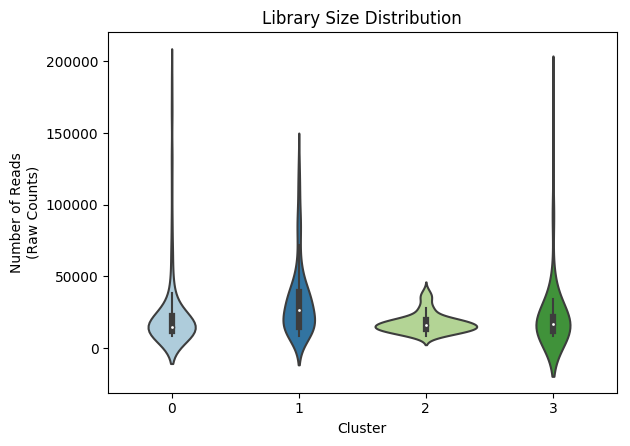

In [31]:
# Estimate of library size
@make_figs(nbconfig.fig_name('reads_by_cluster'), styles=nbconfig.styles_wide, kws_layout={"rect": [0, 0, 1, .95]})
def _plot():
    dat = pd.concat([raw_data.T.sum(axis=1), ident], axis=1).dropna()
    dat.columns = ['raw_counts', 'cluster']
    fig, ax = plt.subplots(1, 1)
    sns.violinplot(dat.cluster, dat.raw_counts, ax=ax, palette=nbconfig.colors)
    ax.set_title('Library Size Distribution')
    ax.set_ylabel('Number of Reads\n(Raw Counts)')
    ax.set_xlabel('Cluster')
    
    labels = []
    for l in ax.get_xticklabels():
        orig = l.get_text().split('.')[0]
        l.set_text(f'{orig}')
        labels.append(l)

    ax.set_xticklabels(labels);

_plot()

Next I look at the distribution of the number of expressed genes by cluster. A gene was considered expressed if it has ≥1 read. Again the clusters look very similar. 

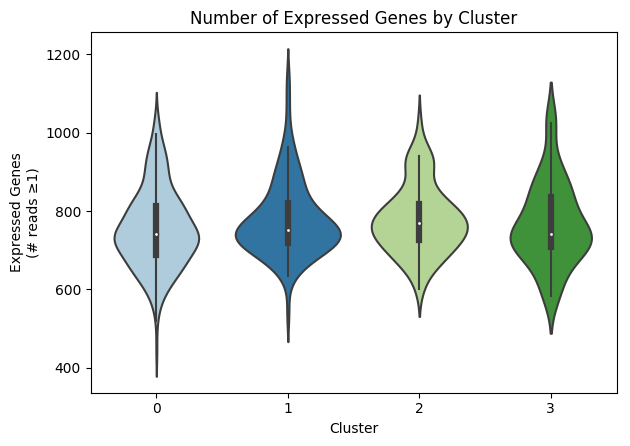

In [32]:
# Expressed Genes
@make_figs(nbconfig.fig_name('genes_expressed_by_cluster'), styles=nbconfig.styles_wide, kws_layout={"rect": [0, 0, 1, .95]})
def _plot(cutoff=1):
    exp_cnts = (norm >= cutoff).sum()
    dat = pd.concat([exp_cnts, ident], axis=1)
    dat.columns = ['expressed_genes', 'cluster']

    fig, ax = plt.subplots(1, 1)
    sns.violinplot(dat.cluster, dat.expressed_genes, palette=nbconfig.colors, ax=ax)
    ax.set_title('Number of Expressed Genes by Cluster')
    ax.set_ylabel(f'Expressed Genes\n(# reads ≥{cutoff})')
    ax.set_xlabel('Cluster')
    
    labels = []
    for l in ax.get_xticklabels():
        orig = l.get_text().split('.')[0]
        l.set_text(f'{orig}')
        labels.append(l)

    ax.set_xticklabels(labels);

_plot()

Finally I looked at average gene expression by cluster. For each gene I calculated the median expression by cluster and then plot the distribution. Clusters behave similarly each having a median expression a little more than 1.5 reads. 

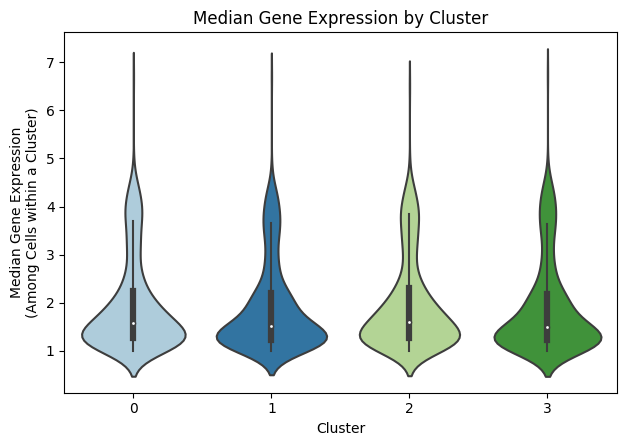

In [33]:
# Distribution of median gene expression
@make_figs(nbconfig.fig_name('median_expression_by_cluster'), styles=nbconfig.styles_wide, kws_layout={"rect": [0, 0, 1, .95]})
def _plot():
    dat = pd.concat([norm.T, ident], axis=1).groupby('ident').median().T.melt()
    dat = dat[(dat.value >= 1)]

    fig, ax = plt.subplots(1, 1)
    sns.violinplot(x=dat.ident, y=(dat.value), ax=ax, palette=nbconfig.colors)
    ax.set_title('Median Gene Expression by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Median Gene Expression\n(Among Cells within a Cluster)')
    
_plot()

# Non-linear dimensionality reduction (tSNE)

Finally we can perform a non-linear dimensionality reduction, also using the PCs, and project these into 2-dimensional space using tSNE.

In [34]:
%%R -o tsne
### Run Non-linear dimensional reduction (tSNE)
ovary = RunTSNE(object=ovary, dims.use=1:21, do.fast=TRUE)

tsne = as.data.frame(ovary@dr$tsne@cell.embeddings)

write.table(tsne,
            file=file.path(OUTPUT, 'tsne.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

# Save 
save(ovary, file = file.path(OUTPUT, "seurat.Robj"))

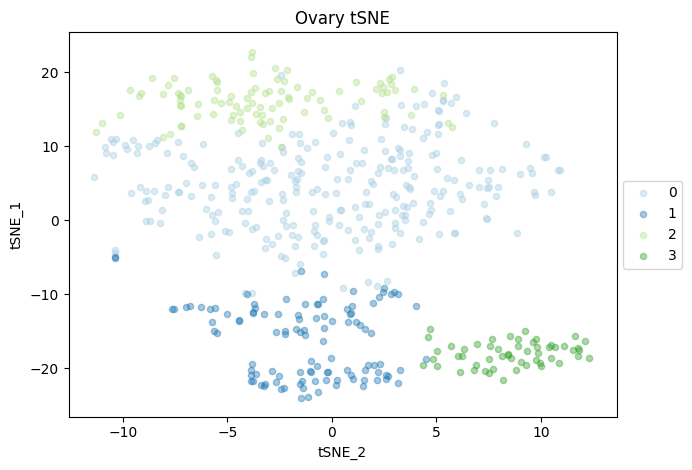

In [35]:
@make_figs(nbconfig.fig_name('tSNE'), nbconfig.styles, nbconfig.formats)
def plot_tSNE():
    _df = tsne.join(ident)
    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue='ident', 
                 palette=nbconfig.colors, alpha=.4, title='Ovary tSNE')
plot_tSNE()

In [46]:
def plot_gene(symbol=None, fbgn=None, **kwargs):
    try:
        if symbol is None:
            symbol = fbgn2symbol[fbgn]

        if fbgn is None:
            fbgn = symbol2fbgn[symbol]

        _df = tsne.join(norm.T.copy()[fbgn])
    except KeyError:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.2, 1]})
    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue=fbgn, s=10, 
             ax=ax1, title='Normalized Expression\n(Continuous)', **kwargs)

    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue=_df[fbgn] > 0, 
             cmap={
                 '0': 'w',
                 '1': 'k',
             }, s=10, ax=ax2, alpha=.6, edgecolor='k', title='Normalized Expression\n(Binary)', **kwargs)

    fig.suptitle(f'{symbol} ({fbgn})');

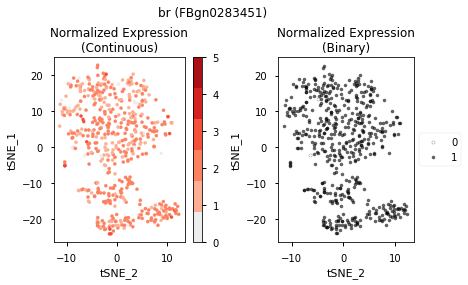

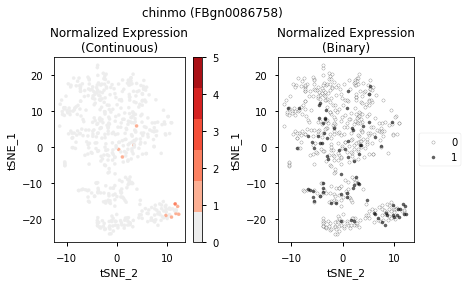

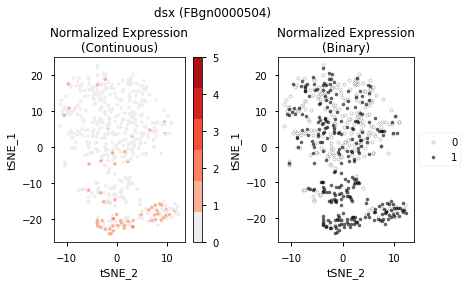

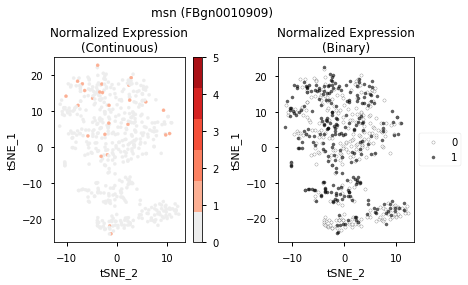

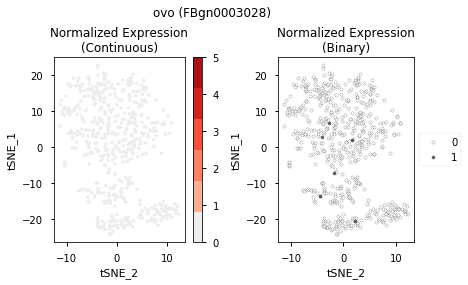

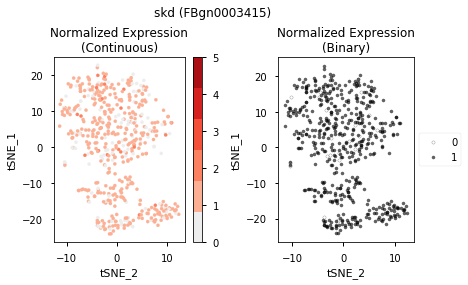

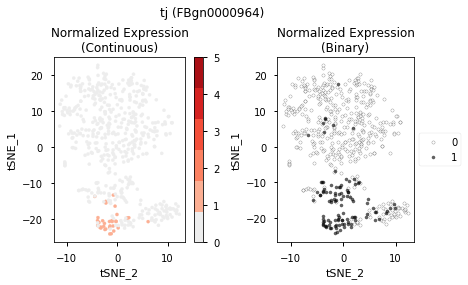

In [47]:
def _plot_gene(*args, **kwargs):
        plot_gene(*args, **kwargs)
        plt.tight_layout(rect=[0, 0, 1, .95])
    
colors = sns.color_palette('Reds')
color2 = sns.color_palette('Greys')
colors[0] = color2[0]

genes = ["bam", "br", "chinmo", "dsx", "msn", "ovo", "skd", "tj", "vas", "otu"]
for g in genes:
    _plot_gene(symbol=g, palette=colors)

# Differential Expression (find biomarkers)

Finally we use Seurat to find differentially expressed genes, which can be used a biomarkers. I require that a gene be present in at least 25% of cells of either cluster (or remaining cells).

**TODO: I am only outputting the positive biomarkers (from Seurat web page), I need to decide if this is what I really want to do.**

In [48]:
%%R -o ovary_markers
### Finding differentially expressed genes (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
ovary_markers = FindAllMarkers(object=ovary, only.pos=TRUE, min.pct=0.25, thresh.use=0.25, print.bar=FALSE)

rownames(ovary_markers) = NULL

ovary_markers %>% group_by(cluster) %>% top_n(2, avg_logFC)

write.table(ovary_markers, 
           file=file.path(OUTPUT, 'biomarkers.tsv'),
           quote=FALSE, sep='\t', row.names=FALSE, col.names=TRUE)

In [49]:
ovary_markers.index = ovary_markers.gene.apply(lambda x: fbgn2symbol[x])
dat = ovary_markers.set_index('gene', append=True).groupby('cluster').head()

In [50]:
HTML(dat.to_html(classes='table table-striped'))

,,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster
gene,gene,,,,,,
CG14642,FBgn0037222,4.050436e-49,0.771075,0.955,0.549,3.229413e-45,0
CG2852,FBgn0034753,2.840932e-43,0.453508,1.000,1.000,2.265075e-39,0
tutl,FBgn0010473,1.672975e-35,0.645293,0.974,0.661,1.333863e-31,0
nuf,FBgn0013718,2.482243e-33,0.557090,0.952,0.615,1.979092e-29,0
lqf,FBgn0028582,4.147889e-30,0.482337,1.000,0.981,3.307112e-26,0
Wnt4,FBgn0010453,1.039166e-67,2.308006,0.964,0.190,8.285273e-64,1
CG44476,FBgn0265669,1.546432e-66,2.278944,0.955,0.192,1.232970e-62,1
Swim,FBgn0034709,1.871455e-66,0.987919,0.909,0.125,1.492111e-62,1
SPARC,FBgn0026562,8.069247e-63,1.596304,1.000,0.272,6.433611e-59,1
